# 逆透視変換による3次元復元

## RealSenseを接続してください．
pyrealsenseを使います．

In [1]:
import pyrealsense2 as rs
import numpy as np
import cv2
from IPython.display import Image, display
import matplotlib.pyplot as plt
%matplotlib inline

# Configure color and depth to run at VGA resolution at 30 frames per second
config = rs.config()
config.enable_stream(rs.stream.depth)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)

## カラー画像と深度画像を取得して表示・保存します．
スペースキーを押す毎に画像が連番で保存されます．'q'を押すと終了します．最後に保存したデータが点群の作成に使われます．

In [13]:
# Start streaming
pipeline = rs.pipeline()
profile = pipeline.start(config)

# Get camera parameters
intr = profile.get_stream(rs.stream.depth).as_video_stream_profile().get_intrinsics()
scale = config.resolve(rs.pipeline_wrapper(pipeline)).get_device().first_depth_sensor().get_depth_scale()

print("focal length(x) in pixels = ", intr.fx)
print("focal length(y) in pixels = ", intr.fy)
print("image height = ", intr.height)
print("image width = ", intr.width)
print("ppx = ", intr.ppx)
print("ppy = ", intr.ppy)

# Create a camera alignment object (depth aligned to color)
align = rs.align(rs.stream.color)
max_depth = 2.0 / scale # Zeros out for any depth greater than 2.0 meters

# Display and save images
print("Press [SPACE] to save images (png) and depth data (npy).")
print("Press 'q' to stop.")
nsaved = 0
try:
    while True:
        # Wait for a coherent pair of frames: depth and color
        frames = pipeline.wait_for_frames()
        aligned_frames = align.process(frames)
        color_frame = aligned_frames.get_color_frame()
        depth_frame = aligned_frames.get_depth_frame()
        if not depth_frame or not color_frame:
            continue

        # Convert images to numpy arrays
        bgr = np.asanyarray(color_frame.get_data())
        depth = np.asanyarray(depth_frame.get_data())
        depth[depth > max_depth] = 0 # Zeros out

        # Apply colormap on depth image (image must be converted to 8-bit per pixel first)
        depth_colormap = cv2.applyColorMap(cv2.normalize(depth, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U), 
                                           cv2.COLORMAP_JET)
  
        images = np.hstack((bgr, depth_colormap))
        # Show images
        cv2.namedWindow('RealSense', cv2.WINDOW_AUTOSIZE)
        cv2.imshow('RealSense', images)
        
        key = cv2.waitKey(33)
        if key == ord(' '):
            Z = depth * scale * 1e+3 # unit in mm
            color = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
            
            # Save images
            cv2.imwrite('color{:02d}pc.png'.format(nsaved), bgr)
            cv2.imwrite('depth{:02d}pc.png'.format(nsaved), depth_colormap)
            np.save('Z{:02d}pc.npy'.format(nsaved), Z)
            
            print("color image and depth data are saved ({:02d})".format(nsaved))
            nsaved += 1

        elif key == ord('q'):
            if nsaved == 0:
                Z = depth * scale * 1e+3 # unit in mm
                color = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
            cv2.destroyAllWindows()
            break
        
finally:
    # Stop streaming
    pipeline.stop()

focal length(x) in pixels =  598.5890502929688
focal length(y) in pixels =  598.5890502929688
image height =  480
image width =  640
ppx =  319.8049621582031
ppy =  230.1638946533203
Press [SPACE] to save images (png) and depth data (npy).
Press 'q' to stop.


## 逆透視変換でポイントクラウドを作りましょう．
カラー画像および点群を作成する深度データを可視化します．

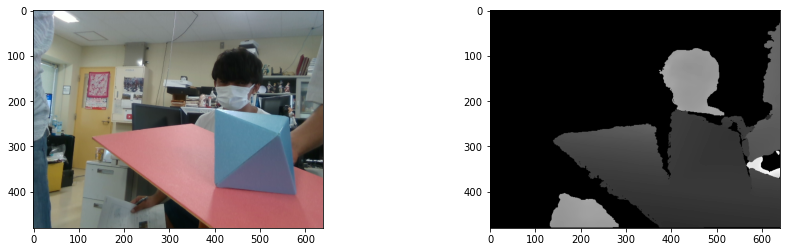

In [14]:
from PIL import Image
height, width, _ = color.shape
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
plt.imshow(color)
plt.subplot(1,2,2)
plt.imshow(Z, cmap="gray")

### 各画素にuとvの座標を設定します．座標系は[予習事項](https://github.com/tsakailab/cisexpkit/blob/master/Experiment/Document/preparation.pdf)の図1です．

In [15]:
# 主点を設定します．
cx, cy = intr.ppx, intr.ppy # width*0.5, height*0.5
j_to_u = lambda j: -(j - cx)
i_to_v = lambda i: -(i - cy)
# 画像平面の座標を設定します．
u, v = np.meshgrid(j_to_u(np.arange(width)), i_to_v(np.arange(height)))
print(u, u.shape)
print(v, v.shape)

[[ 319.80496216  318.80496216  317.80496216 ... -317.19503784
  -318.19503784 -319.19503784]
 [ 319.80496216  318.80496216  317.80496216 ... -317.19503784
  -318.19503784 -319.19503784]
 [ 319.80496216  318.80496216  317.80496216 ... -317.19503784
  -318.19503784 -319.19503784]
 ...
 [ 319.80496216  318.80496216  317.80496216 ... -317.19503784
  -318.19503784 -319.19503784]
 [ 319.80496216  318.80496216  317.80496216 ... -317.19503784
  -318.19503784 -319.19503784]
 [ 319.80496216  318.80496216  317.80496216 ... -317.19503784
  -318.19503784 -319.19503784]] (480, 640)
[[ 230.16389465  230.16389465  230.16389465 ...  230.16389465
   230.16389465  230.16389465]
 [ 229.16389465  229.16389465  229.16389465 ...  229.16389465
   229.16389465  229.16389465]
 [ 228.16389465  228.16389465  228.16389465 ...  228.16389465
   228.16389465  228.16389465]
 ...
 [-246.83610535 -246.83610535 -246.83610535 ... -246.83610535
  -246.83610535 -246.83610535]
 [-247.83610535 -247.83610535 -247.83610535 ... 

### Z, u, vが与えられたとき，X[mm]とY[mm]を計算する関数を作りましょう．[ヒント：予習事項の問2](https://github.com/tsakailab/cisexpkit/blob/master/Experiment/Document/preparation.pdf)

Q11: 関数 Zuv_to_XYを完成させよ．単位mmの深度Zと，画素数の単位をもつ座標u, v, 焦点距離fが与えられているものとする．

In [16]:
focal_length = intr.fx # in pixels
def Zuv_to_XY(Z, u, v, f=focal_length):
    ### X = ________   # Z, u, v, f[0], f[1] から必要なものを使って計算する
    ### Y = ________   # Z, u, v, f[0], f[1] から必要なものを使って計算する
    X = Z*u/f
    Y = Z*v/f
    return X, Y

In [17]:
# Z, u, v から X, Y を計算します．
X, Y = Zuv_to_XY(Z, u, v)

## ポイントクラウドを可視化して観察しましょう．

Q12: 使用した画像のサイズと全画素数，および深度画像の画素値がゼロでない画素の数はいくらか．

Q13: 逆透視変換できない点が生じる原因を複数述べよ．

Q14: [plotly](https://plotly.com/)とは何か．特に，[plotly Graphing Libraries](https://plotly.com/graphing-libraries/)はどのような特長があるか．

Q15: [plotly.graph_objects.Scatter3d](https://plotly.com/python-api-reference/generated/plotly.graph_objects.Scatter3d.html#plotly.graph_objects.Scatter3d)は何ができる関数で，このサンプルコードではどのように使われているか．
> マウスで視点や拡大・縮小をコントロールできます．描画領域右上にある機能も活用しましょう．

In [18]:
nd = np.count_nonzero(Z)
n = 30000
p = np.random.choice(nd, min(n,nd), replace=False)
print("%d out of %d points are displayed." % (n, nd))

import plotly.graph_objs  as go
rgb = color[Z>0][p] # * 1.5 # brighter

trace = go.Scatter3d(x=X[Z>0][p], y=Y[Z>0][p], z=Z[Z>0][p], mode='markers',
                     marker=dict(size=2, 
                                color=['rgb({},{},{})'.format(r,g,b) for r,g,b in zip(rgb[:,0], rgb[:,1], rgb[:,2])],
                                opacity=0.8))

layout = go.Layout(margin=dict(l=0,r=0,b=0,t=0))
fig = go.Figure(data=[trace], layout=layout)
camera = dict(up=dict(x=0, y=0, z=1), center=dict(x=0, y=-0.4, z=0), eye=dict(x=0, y=0.8, z=-2))
fig.update_layout(scene_camera=camera)
fig.show()

30000 out of 115670 points are displayed.
